# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Our final goal
Build a machine learning model that predicts how much someone will spend based on demographics and offer type, and understand the importance of each variable in the model.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

**Skip until the load of the pickle files to not perform again all the initial cleaning**

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Analysis

## Data Exploration and Visualization

### Portfolio

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
# we have not missing values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [7]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
# checking the consistency of the data, the reward and difficulty must be the same for the bogo offers.
bogo_portfolio = portfolio.loc[portfolio.offer_type == "bogo", :]
(bogo_portfolio["difficulty"] == bogo_portfolio["reward"]).mean()

1.0

In [9]:
# the reward and difficulty must be 0 for the informational offers.
informational_portfolio = portfolio.loc[portfolio.offer_type == "informational", :]
print((informational_portfolio["difficulty"] == 0).mean())
print((informational_portfolio["reward"] == 0).mean())

1.0
1.0


In [10]:
# the reward must be lower than the difficulty for the discount offers.
discount_portfolio = portfolio.loc[portfolio.offer_type == "discount", :]
(discount_portfolio["difficulty"] > discount_portfolio["reward"]).mean()

1.0

In [11]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [12]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [13]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [14]:
dummy_channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)

In [15]:
clean_portfolio = pd.concat([portfolio, dummy_channels], axis=1)
clean_portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [16]:
clean_portfolio.drop("channels", axis=1, inplace=True)

### Profile

In [17]:
profile.shape

(17000, 5)

In [18]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [20]:
# transform the became_member_on column from string to date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [21]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [22]:
# checking if the missing values in gender are equal to the income column: yes!
print((profile.gender.isnull() == profile.income.isnull()).mean())
print(profile.gender.isnull().sum()) # number of missing values

1.0
2175


In [23]:
# checking the age and became_member_on columns of the rows with missing values
rows_with_missing_values = profile.loc[profile.gender.isnull(), :]
rows_with_missing_values.age.unique()

array([118])

All the records in the "rows_with_missing_values" contains a very high age! 118 years, considering the highest life expectancy by country (around 83.7 years old, [https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy]) and the missing values in the columns "gender" and "income" I decide to remove this rows.

In [24]:
profile = profile.loc[profile.gender.notnull(), :]

In [25]:
profile.shape

(14825, 5)

In [26]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [27]:
# no missing values, great!
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

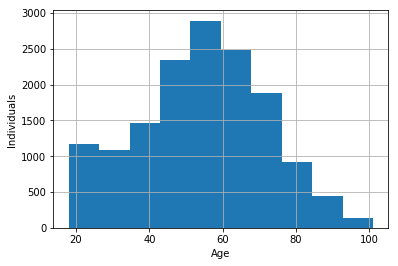

In [28]:
g = profile.age.hist();
g.set_xlabel("Age");
g.set_ylabel("Individuals");

The above visualization is showing us that age has almost a normal distribution, with the exception of the number of individuals between 20 and 40 years old.

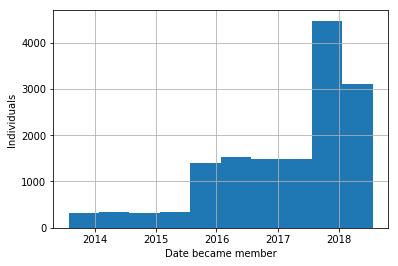

In [29]:
g = profile.became_member_on.hist();
g.set_xlabel("Date became member");
g.set_ylabel("Individuals");

The above visualization is showing us that over time more and more clients are being members of the Starbucks platform, starting in the 2013.

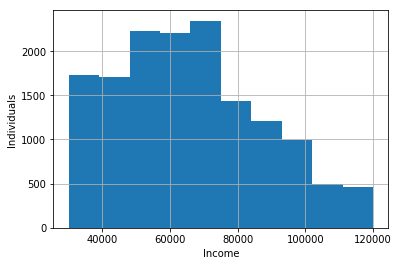

In [30]:
g = profile.income.hist();
g.set_xlabel("Income");
g.set_ylabel("Individuals");

The income visualization is showing us that the income is low or normal (70.000 or fewer) for the majority of the individuals, the highest incomes are related with few individuals.

In [31]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [32]:
sns.relplot(data=profile, x="age", y="income", hue="gender");

AttributeError: module 'seaborn' has no attribute 'relplot'

In [ ]:
print(profile.loc[profile.age <= 30, "income"].max())
print(profile.loc[(profile.age >= 40) & (profile.age <= 45), "income"].max())

Clearly, we can observe two interesting facts in the above plot:
#### The clear limit in incomes respect to the age:####

* 20-~40 years old, the highest income is 75.000
* ~40-~50 years old, the highest income is 100.000
* ~50+ years old, the highest income is 120.000

#### The heterogeneity of the genders along with the age and income ####

In [ ]:
sns.boxplot(x="gender", y="age", data=profile);

In our dataset the mean age of the women is greater than the males and others, additionally, the mean age of the others is greater than the males.
In female individuals, we can observe some "anomalies" because their age is greater than the whiskers value.

In [ ]:
sns.boxplot(x="gender", y="income", data=profile);

In [ ]:
print(profile.loc[profile.gender == "F", "income"].mean(), profile.loc[profile.gender == "F", "income"].std())
print(profile.loc[profile.gender == "M", "income"].mean(), profile.loc[profile.gender == "M", "income"].std())
print(profile.loc[profile.gender == "O", "income"].mean(), profile.loc[profile.gender == "O", "income"].std())

In [33]:
# income: F vs M
print(((71306.412139/61194.601603)-1)*100)
# income: F vs O
print(((71306.412139/63287.7358491)-1)*100)

16.524023804583887
12.670189859563497


The mean income of the women is over 16% respect to the mean income of the men and over 12% respect to the others. Nevertheless, the standard deviation in the women income is higher than the men and others.

Finally, in male individuals, we can observe some "anomalies" because their income is greater than the whiskers value.

In [34]:
clean_profile = profile.copy()

### Transcript

In [35]:
transcript.shape

(306534, 4)

In [36]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [37]:
# No missing values! Nice!
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [38]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [39]:
unique_persons_in_transcript = transcript.person.unique()
unique_persons_in_profile = clean_profile.id.values
id_of_persons_who_are_not_in_profile = [person_id for person_id in unique_persons_in_transcript if not(person_id in unique_persons_in_profile)]

In [40]:
# Percentage of people who is not in the profile dataset but appears in the transcript dataset
print(len(id_of_persons_who_are_not_in_profile)/len(transcript.person.unique()) * 100)
print(len(id_of_persons_who_are_not_in_profile))

12.794117647058822
2175


In [41]:
all(rows_with_missing_values.id.sort_values().values == pd.Series(id_of_persons_who_are_not_in_profile).sort_values().values)

True

As we expected, the individuals who are not in the profile dataset but appears in the transcript dataset correspond to the dropped individuals with missing data in the cleaning process of the profile dataset.

In [42]:
[person_id for person_id in unique_persons_in_profile if not(person_id in unique_persons_in_transcript)]

[]

All the persons in the profile are present in the transcript dataset! Excellent, all our individuals contains at least one interation with the system!

**We will only remain with the valid individuals of the profile dataset in our transcript dataset**

In [43]:
transcript = transcript.loc[transcript.person.isin(unique_persons_in_profile), :]

In [44]:
transcript.shape

(272762, 4)

In [45]:
100-(272762/306534*100)

11.017374907840562

**We remove the 11.02% of the transcript data associated with the individuals with missing values in gender and income in the profile dataset!**

In [46]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [47]:
clean_transcript = pd.concat([transcript, transcript.value.apply(pd.Series)], axis=1)

In [48]:
clean_transcript.drop("value", axis=1, inplace=True)

In [49]:
clean_transcript.tail()

,event,person,time,offer id,amount,offer_id,reward
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,NaN,1.59,NaN,NaN
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,NaN,9.53,NaN,NaN
306531,transaction,a00058cf10334a308c68e7631c529907,714,NaN,3.61,NaN,NaN
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,NaN,3.53,NaN,NaN


In [50]:
clean_transcript.isnull().sum()

event            0
person           0
time             0
offer id    156401
amount      148805
offer_id    240318
reward      240318
dtype: int64

We can observe that now exists two similar columns "offer id" and "offer_id", we must join them because probably existed an error in the dropped column "value".

In [51]:
clean_transcript.loc[:, "clean_offer_id"] = clean_transcript.apply(lambda row: row["offer id"] if pd.isnull(row["offer_id"]) else row["offer_id"], axis=1)

In [52]:
(clean_transcript.loc[:, "clean_offer_id"] == clean_transcript.loc[:, "offer_id"]).sum()

32444

In [53]:
clean_transcript.loc[:, "offer_id"].notnull().sum()

32444

In [54]:
(clean_transcript.loc[:, "clean_offer_id"] == clean_transcript.loc[:, "offer id"]).sum()

116361

In [55]:
clean_transcript.loc[:, "offer id"].notnull().sum()

116361

The new column "clean_offer_id" contains the real id of the offer, now we will drop the previous columns.

In [56]:
clean_transcript.drop("offer id", axis=1, inplace=True)
clean_transcript.drop("offer_id", axis=1, inplace=True)

Finally we must check if each row contains at least one value in any of the following columns: "amount", "clean_offer_id" or "reward".

In [57]:
any(clean_transcript[["amount", "clean_offer_id", "reward"]].notnull().sum(axis=1) == 0)

False

Perfect! We can proceed! Each row contains at least one value in those columns.

In [58]:
clean_transcript.isnull().sum()

event                  0
person                 0
time                   0
amount            148805
reward            240318
clean_offer_id    123957
dtype: int64

We are merging all the datasets, with the person_id no exists any problem because each row contains values! Nevertheless, the offer_id contains null values, so the merge process must be done using the how parameter with value "outer"

In [59]:
merge_transcript = clean_transcript.merge(clean_portfolio, left_on="clean_offer_id", right_on="id", suffixes=('', '_portfolio'), how="outer")
merge_transcript.shape

(272762, 15)

In [60]:
merge_transcript = merge_transcript.merge(clean_profile, left_on="person", right_on="id", suffixes=('', '_profile'))
merge_transcript.shape

(272762, 20)

Nevertheless, the column "clean_offer_id" must have one value which indicates the offer associated with the record (row) if exists a offer valid (by the duration of itself), I will assume that a NaN value will be associated with the offer_id immediately previous (respect to the date)if and only if it offer.

In [61]:
merge_transcript.loc[merge_transcript.clean_offer_id.isnull(),:].event.unique()

array(['transaction'], dtype=object)

In [62]:
merge_transcript.clean_offer_id.isnull().sum() / merge_transcript.shape[0]

0.45445113322236969

45% of the transcript records do not contains offer id and their event is "transaction"

In [63]:
merge_transcript = merge_transcript.sort_values(["person", "time"])

In [64]:
merge_transcript.head()

,event,person,time,amount,reward,clean_offer_id,difficulty,duration,id,offer_type,reward_portfolio,email,mobile,social,web,age,became_member_on,gender,id_profile,income
164528,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0
164529,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0
164530,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0
164523,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0
164524,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0


In [65]:
merge_transcript.drop("id", axis=1, inplace=True)

In [66]:
merge_transcript.drop("id_profile", axis=1, inplace=True)

In [67]:
merge_transcript.head(20).iloc[4:10, :]

,event,person,time,amount,reward,clean_offer_id,difficulty,duration,offer_type,reward_portfolio,email,mobile,social,web,age,became_member_on,gender,income
164524,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,72000.0
164520,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,72000.0
164521,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,72000.0
164531,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,72000.0
164522,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,72000.0
164525,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,72000.0


In the above situation for the rows with index 164520, 164521, 164531 and 164522 we can observe one error in the system, because in the time 408 we receive the "f19421c1d4aa40978ebb69ca19b0e20d" offer (bogo of 5), the client perform a transaction of 8.57 in the time = 414 and the record of offer completed is generated, nevertheless the offer contains a duration = 5.

(Buy time - Initial time) must be <= duration; if the offer will be valid.

BUT:

414 - 408 = 6; <= 5 --> Should not be valid!

**I will omit this situation because the error is probably replicated along the dataset, nevertheless, it's a situation where the data analysis generates a system revision for the reliability of itself**

In [68]:
merge_transcript.shape

(272762, 18)

In [69]:
def get_previous_offer_received_records_from_person(person, time, transcripts=merge_transcript):
    # records of the person
    transcripts_of_person = transcripts#transcripts.loc[transcripts.person == person, :]
    # records of the person before certain "time" and = "offer received"
    transcripts_offers_received_of_person = transcripts_of_person.loc[(transcripts_of_person.time <= time) & (transcripts_of_person.event == "offer received"), :]
    # get closest offer received
    closest_offer_received = transcripts_offers_received_of_person.sort_values("time", ascending=False)
    
    if closest_offer_received.shape[0] == 0:
        return np.nan
    
    closest_offer_received = closest_offer_received.iloc[0,:]
    
    if (time - closest_offer_received["time"]) <= closest_offer_received["duration"]:
        return closest_offer_received["clean_offer_id"]

In [70]:
def search_for_previous_offer_if_contains_nan(row, data_of_person):
    if pd.isnull(row["clean_offer_id"]) == False:
        return row
    row["clean_offer_id"] = get_previous_offer_received_records_from_person(row["person"], row["time"], data_of_person)
    return row

In [71]:
aux = merge_transcript.copy()
aux = aux[["clean_offer_id", "person", "time", "duration", "event"]]

In [72]:
unique_persons = aux.person.unique()

In [75]:
merge_transcript.to_pickle("merge_transcript.pkl")

In [74]:
aux.to_pickle("aux.pkl")

In [77]:
np.save('unique_persons.npy', unique_persons)

## Here we continue the analysis with the pickle

In [3]:
aux = pd.read_pickle("final.pkl")
merge_transcript = pd.read_pickle("merge_transcript.pkl")

In [4]:
all(aux.index == merge_transcript.index)

True

In [5]:
merge_transcript.loc[:, "clean_offer_id"] = aux.loc[:, "clean_offer_id"]

In [6]:
merge_transcript.shape

(272762, 18)

Performing the following analysis I observed some cases where one offer was completed twice at the same time for the same person, I will remove this duplicates

In [7]:
merge_transcript.drop_duplicates(inplace=True)

In [8]:
merge_transcript.shape

(272388, 18)

Currently, we have a big problem, and it is the reliability of the dataset (exposed previously). One approximation to solve it is to check that at least the number of offer completed is the same as the number of transactions associated with a clean_offer_id, it will indicate **minimum** that an offer was completed through one the only transaction buy was perform.

In [9]:
def generate_count_of_offer_id_null_and_not_null(merge_transcript):
    transaction_without_offer = merge_transcript.copy()
    transaction_without_offer = transaction_without_offer.loc[transaction_without_offer.event == "transaction",:]
    transaction_without_offer["null_offer"] = transaction_without_offer.clean_offer_id.isnull()
    transaction_without_offer["not_null_offer"] = transaction_without_offer.clean_offer_id.notnull()

    # null_offer --> mean = 1, indicates that all the transactions where performed without the influence of an offer
    agg_person_null_offer = transaction_without_offer[["person", "null_offer", "not_null_offer"]].groupby("person").agg(["mean", "sum"]).reset_index()
    agg_person_null_offer.columns = ["person", "null_mean", "null_count", "not_null_mean", "not_null_count"]

    agg_person_null_offer.head()


    offers_completed = merge_transcript.copy()
    offers_completed = offers_completed.loc[offers_completed.event == "offer completed",:]


    person_offers_completed = offers_completed[["person", "event"]].groupby("person").count().reset_index()
    person_offers_completed.columns = ["person", "count_offer_completed"]

    merge_agg_person = agg_person_null_offer.merge(person_offers_completed)


    merge_agg_person.head()


    percentage_of_valid_persons = (merge_agg_person.not_null_count >= merge_agg_person.count_offer_completed).mean()*100
    
    merge_agg_person["to_complete"] = merge_agg_person.not_null_count - merge_agg_person.count_offer_completed
    persons_to_fix = merge_agg_person.loc[merge_agg_person.to_complete < 0, ["person", "to_complete"]]
    return persons_to_fix, percentage_of_valid_persons

In [10]:
persons_to_fix, percentage_of_valid_persons = generate_count_of_offer_id_null_and_not_null(merge_transcript)

In [11]:
print(percentage_of_valid_persons)

9.7363590856


Only 9.74% of the persons contains valid data about the offer and the completion of them. We need to give some fix to this issue.

In [12]:
persons_to_fix.head()

,person,to_complete
0,0009655768c64bdeb2e877511632db8f,-2.0
1,0011e0d4e6b944f998e987f904e8c1e5,-3.0
2,0020c2b971eb4e9188eac86d93036a77,-3.0
3,0020ccbbb6d84e358d3414a3ff76cffd,-3.0
4,003d66b6608740288d6cc97a6903f4f0,-2.0


In [13]:
fixed_merge = merge_transcript.copy()
fixed_merge.sort_values(["person", "time"], ascending=[True, False], inplace=True)
aux = fixed_merge.copy()

**The result of the following process was saved as a pickle file**

In [42]:
_transactions = aux.event=="transaction"
_not_associated = pd.isnull(aux.clean_offer_id)
_offers_completed = aux.event=="offer completed"
_total = persons_to_fix.shape[0]
_cont = 0
for index, row in persons_to_fix.iterrows():
    if _cont%100 == 0:
        print(_cont/_total*100, "%")
    p = row["person"]
    to_complete = int(row["to_complete"]*-1)
    
    person_aux = aux.loc[(aux.person == p) & (_transactions) & (_not_associated) , :]
    index_to_chage_offer_id = person_aux.index[:int(to_complete)]
    # offers associated to the transactions
    person_offers_in_transactions = list(aux.loc[(aux.person == p) & (_transactions) & (~_not_associated) , "clean_offer_id"])
    # offers completed of the person
    person_offers_completed_aux = list(aux.loc[(aux.person == p) & (_offers_completed) , "clean_offer_id"])
    
    for _offer_id in person_offers_in_transactions:
        try:
            person_offers_completed_aux.remove(_offer_id)
        except Exception as e:
            # here will be the offers whose have transactions but were not completed
            pass
    
    offers_not_associated = person_offers_completed_aux[:to_complete]
    
    try:
        # the final part [:len(index_to_chage_offer_id)] exists because for some person he contains two offers
        # at the same time and they are completed with just one transaction
        fixed_merge.loc[index_to_chage_offer_id, "clean_offer_id"] = offers_not_associated[:len(index_to_chage_offer_id)]
    except Exception as e:
        print("=================")
        print(p)
        print(index_to_chage_offer_id)
        print(offers_not_associated)
        raise e
    
    _cont += 1

0.0 %
0.9242998428690268 %
1.8485996857380536 %
2.77289952860708 %
3.697199371476107 %
4.621499214345134 %
5.54579905721416 %
6.470098900083188 %
7.394398742952214 %
8.318698585821242 %
9.242998428690267 %
10.167298271559295 %
11.09159811442832 %
12.015897957297348 %
12.940197800166375 %
13.864497643035401 %
14.788797485904428 %
15.713097328773454 %
16.637397171642483 %
17.561697014511505 %
18.485996857380535 %
19.41029670024956 %
20.33459654311859 %
21.25889638598761 %
22.18319622885664 %
23.107496071725667 %
24.031795914594696 %
24.95609575746372 %
25.88039560033275 %
26.804695443201776 %
27.728995286070802 %
28.653295128939828 %
29.577594971808857 %
30.501894814677883 %
31.426194657546908 %
32.350494500415934 %
33.27479434328497 %
34.199094186153985 %
35.12339402902301 %
36.04769387189204 %
36.97199371476107 %
37.896293557630095 %
38.82059340049912 %
39.74489324336815 %
40.66919308623718 %
41.593492929106205 %
42.51779277197522 %
43.442092614844256 %
44.36639245771328 %
45.290692300

In [43]:
#fixed_merge.to_pickle("fixed_merge.pkl")

In [14]:
fixed_merge = pd.read_pickle("fixed_merge.pkl")

In [15]:
_df, percentage_valid = generate_count_of_offer_id_null_and_not_null(fixed_merge)

In [16]:
percentage_valid

98.840313699315871

The 98.84% of the persons contains valid data about the offer and the completion of them. I will remove the 1.16% left.

In [17]:
fixed_merge = fixed_merge.loc[~fixed_merge.person.isin(_df.person.values), :]

In [18]:
fixed_merge = fixed_merge.sort_values(["person", "time"])

# Modeling

**Build a machine learning model that predicts how much someone will spend based on demographics and offer type, and understand the importance of each variable in the model.**

In [19]:
fixed_merge.reset_index(inplace=True)
fixed_merge.drop("index", axis=1, inplace=True)

In [20]:
unique_persons = fixed_merge.person.unique()

In [22]:
def unificar_registros(rows_person, inicio, fin):
    registros_asociados = rows_person.loc[inicio:fin, :]
    registros_asociados_in_time = registros_asociados.loc[registros_asociados.time <= registros_asociados.time.values[0] + registros_asociados.duration.values[0], :]
    primer_registro = registros_asociados.iloc[0,:][["difficulty",
                       "duration", "offer_type", "reward_portfolio", "email",
                       "mobile", "social", "web", "age",
                       "gender", "income"]].to_dict()
    primer_registro["money_spend"] = registros_asociados.amount.sum()
    return primer_registro

In [23]:
def sort_rows_by_person_and_offer_received(df, unique_persons):
    registros = []
    _cont = 0
    _total = len(unique_persons)
    for unique_person in unique_persons:
        if _cont % 100 == 0:
            print("{0:.2f}%".format(_cont/_total*100))
        rows_person = df.loc[df.person.isin([unique_person]), :]

        indices = rows_person.index[rows_person.event.isin(["offer received"])]
        indice_inicio = pd.Series(indices[:-1])
        indice_fin = pd.Series((indices-1)[1:])
        
        indices = pd.concat([indice_inicio, indice_fin], axis=1)
        
        for _, row in indices.iterrows():
            inicio, fin = row[0], row[1]
            registros.append(unificar_registros(rows_person, inicio, fin))
        _cont += 1
    return registros

**The result of the following process was saved as a pickle file**

In [24]:
final_df = sort_rows_by_person_and_offer_received(fixed_merge, unique_persons)

0.00%
0.68%
1.36%
2.04%
2.72%
3.40%
4.09%
4.77%
5.45%
6.13%
6.81%
7.49%
8.17%
8.85%
9.53%
10.21%
10.89%
11.58%
12.26%
12.94%
13.62%
14.30%
14.98%
15.66%
16.34%
17.02%
17.70%
18.38%
19.07%
19.75%
20.43%
21.11%
21.79%
22.47%
23.15%
23.83%
24.51%
25.19%
25.87%
26.56%
27.24%
27.92%
28.60%
29.28%
29.96%
30.64%
31.32%
32.00%
32.68%
33.37%
34.05%
34.73%
35.41%
36.09%
36.77%
37.45%
38.13%
38.81%
39.49%
40.17%
40.86%
41.54%
42.22%
42.90%
43.58%
44.26%
44.94%
45.62%
46.30%
46.98%
47.66%
48.35%
49.03%
49.71%
50.39%
51.07%
51.75%
52.43%
53.11%
53.79%
54.47%
55.15%
55.84%
56.52%
57.20%
57.88%
58.56%
59.24%
59.92%
60.60%
61.28%
61.96%
62.64%
63.33%
64.01%
64.69%
65.37%
66.05%
66.73%
67.41%
68.09%
68.77%
69.45%
70.13%
70.82%
71.50%
72.18%
72.86%
73.54%
74.22%
74.90%
75.58%
76.26%
76.94%
77.62%
78.31%
78.99%
79.67%
80.35%
81.03%
81.71%
82.39%
83.07%
83.75%
84.43%
85.12%
85.80%
86.48%
87.16%
87.84%
88.52%
89.20%
89.88%
90.56%
91.24%
91.92%
92.61%
93.29%
93.97%
94.65%
95.33%
96.01%
96.69%
97.37%
98.05%


In [25]:
final_df = pd.DataFrame(final_df)

In [27]:
final_df.shape

(51100, 12)

In [28]:
#final_df.to_pickle("final_df.pkl")

In [22]:
final_df = pd.read_pickle("final_df.pkl")

We need our data as dummies variables because our regression models handle only numeric values!

In [29]:
final_df = pd.get_dummies(final_df)

In [30]:
final_df.columns

Index(['age', 'difficulty', 'duration', 'email', 'income', 'mobile',
       'money_spend', 'reward_portfolio', 'social', 'web', 'gender_F',
       'gender_M', 'gender_O', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational'],
      dtype='object')

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [32]:
X = final_df.drop('money_spend', axis=1)
Y = final_df[['money_spend']].copy()

In [33]:
nombre_columnas = X.columns

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Clearly, we need to scale our data because we wanna compare fairly the coefficients to understand the relation between them and our dependent variable (money spend).

In [35]:
x_scaler = StandardScaler()
x_scaler.fit(X_train)

y_scaler = StandardScaler()
y_scaler.fit(Y_train);

In [36]:
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

Y_train = y_scaler.transform(Y_train)
Y_test = y_scaler.transform(Y_test)

### Random Forest Regressor

In [39]:
def random_forest_model():
    # creates the grid search using random forest regressor
    rf_clf = RandomForestRegressor(random_state=42)

    parameters = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, None],
        'min_samples_split': [2, 3, 4]
    }

    cv = GridSearchCV(rf_clf, param_grid=parameters)

    return cv

In [40]:
rf_clf = random_forest_model()
rf_clf.fit(X_train, Y_train.reshape(-1))

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [5, 7, None], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
rf_clf.best_params_

{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 200}

In [42]:
importance_of_each_column = pd.DataFrame({'features': nombre_columnas, 'importance': rf_clf.best_estimator_.feature_importances_})

In [43]:
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
4,income,0.641636
7,social,0.090869
0,age,0.073327
10,gender_M,0.047691
2,duration,0.037640
14,offer_type_informational,0.028381
1,difficulty,0.020169
6,reward_portfolio,0.017049
9,gender_F,0.016850
13,offer_type_discount,0.009502


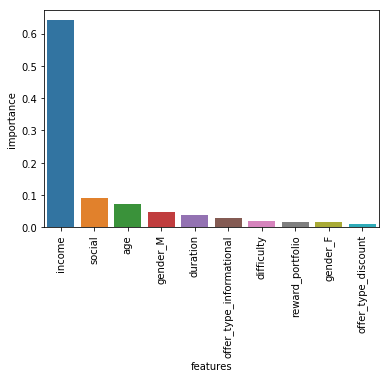

In [44]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [45]:
Y_pred = rf_clf.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

0.99008665517551775

### Ridge

In [46]:
def ridge_model():
    # creates the grid search using ridge
    ridge = Ridge(random_state=42)

    parameters = {
        'alpha': [1, 2, 3],
    }

    cv = GridSearchCV(ridge, param_grid=parameters)

    return cv

In [47]:
lr = ridge_model()
lr.fit(X_train, Y_train.reshape(-1))

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 2, 3]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [48]:
lr.best_params_

{'alpha': 3}

In [49]:
importance_of_each_column = pd.DataFrame({'features': nombre_columnas, 'importance': lr.best_estimator_.coef_})

In [50]:
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
4,income,0.169553
2,duration,0.080544
7,social,0.071854
5,mobile,0.050373
9,gender_F,0.024505
8,web,0.022685
6,reward_portfolio,0.016509
14,offer_type_informational,0.013914
11,gender_O,0.009690
1,difficulty,0.003026


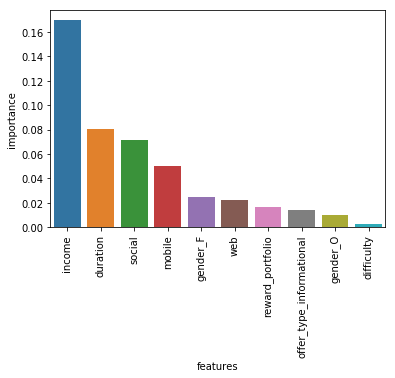

In [51]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [52]:
Y_pred = lr.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

0.9926199633652677

### Lasso

In [53]:
def lasso_model():
    # creates the grid search using lasso
    ridge = Lasso(random_state=42)

    parameters = {
        'alpha': [1, 2, 3],
    }

    cv = GridSearchCV(ridge, param_grid=parameters)

    return cv

In [54]:
lr = lasso_model()
lr.fit(X_train, Y_train.reshape(-1))

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 2, 3]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [55]:
lr.best_params_

{'alpha': 1}

In [56]:
importance_of_each_column = pd.DataFrame({'features': nombre_columnas, 'importance': lr.best_estimator_.coef_})

In [57]:
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
0,age,0.0
1,difficulty,0.0
2,duration,0.0
3,email,0.0
4,income,0.0
5,mobile,0.0
6,reward_portfolio,0.0
7,social,0.0
8,web,0.0
9,gender_F,0.0


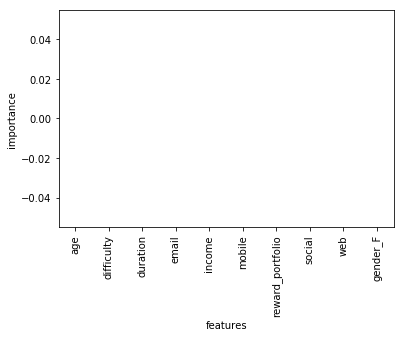

In [58]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [59]:
Y_pred = lr.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

1.010943021011651

In [60]:
y_scaler.inverse_transform(Y_pred)

array([ 23.47193297,  23.47193297,  23.47193297, ...,  23.47193297,
        23.47193297,  23.47193297])

In [61]:
lr.best_estimator_.intercept_

2.7114644515307149e-17

In [62]:
y_scaler.inverse_transform([lr.best_estimator_.intercept_])

array([ 23.47193297])

I used GridSearch to find the best possible parameters in each model! Instead of use the defaults parameters in each model. 

**Observations:**
We can observe that all the coefficients in the Lasso method are 0.0 !! That means all the predicted values are the same (the value of the intercept = 2.7114644515307149e-17, and with the reverse scaling  = 23.47193297).

A way to highly improve our results is to check the consistency of the system presented before. Additionally, get more data about the clients and navigation habits around the Starbucks Platform.

Looking at our results we are gonna discard the Lasso Method because it does not allow us to understand the relation of our independent variables with the dependent.

Using our RMSE metric we can conclude that our Random Forest method is better than the Ridge method in this particular problem, nevertheless, we can observe a correspondence in huge results in those methods, the importance of the income related to the spend money.

**Final results:**
The important variables if we wanna focus on the clients whose money spend in our business is the highest are:
* income: clients with higher income will spend more.
* social: offers communicated with the clients through the social generates more spend
* age
* gender_M: the males are related to spending more in Starbucks
* duration: offers with higher duration will attract more clients.

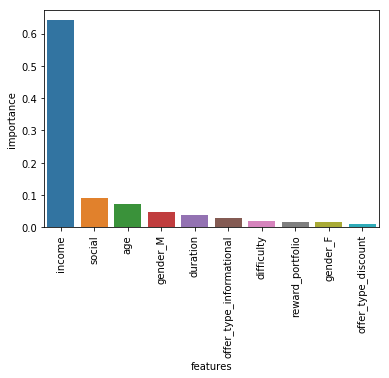

**Difficulties:**
The way to handle the problems and create the relation between offers and transactions was a hard part. Additionally, the way to confront a problem from scratch.